# Fraud Classification - Data Preparation (Optional)
<BR><BR>The purpose of this notebook is for a Data Scientist to update amount of fraud data and create correlations between potential features (time, customer information, card information, etc.) and fraud. The PAL Partition function is used to ensure repeatable generation of data using a random number generator and partial fraud cases based on probability.

### Steps in this notebook
-  Connect to SAP HANA
-  Create a SAP HANA DataFrame which points to the data
-  Take a more detailed look at the data
-  Update the fraud flags to create more balanced dataset for classification algorithms

### Documentation
-  SAP HANA Python Client API for Machine Learning Algorithms:   
   https://help.sap.com/doc/0172e3957b5946da85d3fde85ee8f33d/latest/en-US/html/hana_ml.html
-  SAP HANA Predictive Analysis Library (PAL):  
   https://help.sap.com/viewer/319d36de4fd64ac3afbf91b1fb3ce8de/cloud/en-US
-  SAP HANA Automated Predictive Library (APL):
   https://help.sap.com/viewer/product/apl/2018/en-US

### Create a SAP HANA DataFrame, which points to the initial data
Instantiate a connecton object to SAP HANA.
-  For simplicity, to help you get started, these values are hardcoded here. 
-  We recommend keeping these credentials in the Secure User Store of the SAP HANA Client. Retrieving the credentials from the Secure User Store prevents having to specify these credentials in clear text. 

In [1]:
import hana_ml.dataframe as dataframe
conn = dataframe.ConnectionContext(key = 'NA_POC_HANA_CLOUD', encrypt = 'true',sslValidateCertificate = 'false')

Create the SAP HANA DataFrame, which points to the initial table. No data is extracted.

In [2]:
df_pushdown = conn.table(table = 'CARD_TRANSACTIONS_JULY_2020', schema = 'BIUSER')

### Peek at the data and retrieve a small number of rows

In [3]:
df_pushdown.head(5).collect()

,CT_ID,CT_DATE,CT_CARD_ID,CT_CUST_ID,CT_MER_ID,CT_AMOUNT,CT_FEE,CT_FLAG_FRAUD,CT_STATUS,CT_DAYDATE
0,129814245,2020-07-01 05:09:28,184460,184460,6927,20.19,0.21,1,1,2020-07-01
1,129818127,2020-07-01 08:10:08,198835,198835,7011,20.28,0.21,0,1,2020-07-01
2,129861468,2020-07-01 22:52:11,212806,212806,5209,19.66,0.21,0,1,2020-07-01
3,129857633,2020-07-01 21:10:11,191057,191057,6059,20.13,0.21,0,1,2020-07-01
4,129856028,2020-07-01 20:53:39,101379,101379,7010,20.18,0.21,0,1,2020-07-01


### Row count
Retrieve the number of rows / observations in the dataset.

In [4]:
df_pushdown.count()

1689500

### Column maximum
Various functions on the SAP HANA DataFrame allow to push calculation down to SAP HANA. Have SAP HANA find the most expensive transaction in the dataset.

In [5]:
df_pushdown.agg([('max', 'CT_AMOUNT', 'MOSTEXPENSIVE')]).collect()

,MOSTEXPENSIVE
0,5000.64


### Descriptive statistics 
Display most important data column statistics. All values were calculated within SAP HANA. 

In [6]:
df_pushdown.describe().collect()

,column,count,unique,nulls,mean,std,min,max,median,25_percent_cont,25_percent_disc,50_percent_cont,50_percent_disc,75_percent_cont,75_percent_disc
0,CT_ID,1689500,1689500,0,1.306563e+08,487716.784235,1.298115e+08,1.315010e+08,1.306563e+08,1.302339e+08,1.302339e+08,1.306563e+08,1.306562e+08,1.310786e+08,1.310786e+08
1,CT_CARD_ID,1689500,566689,0,3.401081e+05,265260.525894,1.000010e+05,9.999980e+05,1.965600e+05,1.482570e+05,1.482570e+05,1.965595e+05,1.965590e+05,5.168762e+05,5.168760e+05
2,CT_CUST_ID,1689500,566689,0,3.401081e+05,265260.525894,1.000010e+05,9.999980e+05,1.965600e+05,1.482570e+05,1.482570e+05,1.965595e+05,1.965590e+05,5.168762e+05,5.168760e+05
3,CT_MER_ID,1689500,46808,0,1.770374e+04,13808.532331,5.201000e+03,5.200800e+04,1.022700e+04,7.712000e+03,7.712000e+03,1.022700e+04,1.022700e+04,2.692200e+04,2.692200e+04
4,CT_AMOUNT,1689500,85536,0,1.264452e+02,410.360000,1.110000e+01,5.000640e+03,2.712000e+01,1.691000e+01,1.691000e+01,2.712000e+01,2.712000e+01,8.019000e+01,8.019000e+01
5,CT_FEE,1689500,15039,0,3.723969e+00,16.500000,1.200000e-01,4.499000e+02,7.700000e-01,2.400000e-01,2.400000e-01,7.700000e-01,7.700000e-01,1.830000e+00,1.830000e+00
6,CT_FLAG_FRAUD,1689500,2,0,9.909914e-02,0.298795,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
7,CT_STATUS,1689500,1,0,1.000000e+00,0.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
8,CT_DATE,1689500,629354,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,CT_DAYDATE,1689500,31,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Display the SELECT statement that was automatically created to obtain the above statistics. The syntax might be useful for transparency, verification or modification.

In [7]:
df_pushdown.describe().select_statement

'SELECT * FROM (SELECT "SimpleStats".*, "Percentiles"."25_percent_cont", "Percentiles"."25_percent_disc", "Percentiles"."50_percent_cont", "Percentiles"."50_percent_disc", "Percentiles"."75_percent_cont", "Percentiles"."75_percent_disc" FROM (select \'CT_ID\' as "column", COUNT("CT_ID") as "count", COUNT(DISTINCT "CT_ID") as "unique", SUM(CASE WHEN "CT_ID" is NULL THEN 1 ELSE 0 END) as "nulls", AVG(TO_DOUBLE("CT_ID")) as "mean", STDDEV("CT_ID") as "std", MIN("CT_ID") as "min", MAX("CT_ID") as "max", MEDIAN("CT_ID") as "median" FROM (SELECT * FROM "BIUSER"."CARD_TRANSACTIONS_JULY_2020") AS "DT_0" UNION ALL select \'CT_CARD_ID\' as "column", COUNT("CT_CARD_ID") as "count", COUNT(DISTINCT "CT_CARD_ID") as "unique", SUM(CASE WHEN "CT_CARD_ID" is NULL THEN 1 ELSE 0 END) as "nulls", AVG(TO_DOUBLE("CT_CARD_ID")) as "mean", STDDEV("CT_CARD_ID") as "std", MIN("CT_CARD_ID") as "min", MAX("CT_CARD_ID") as "max", MEDIAN("CT_CARD_ID") as "median" FROM (SELECT * FROM "BIUSER"."CARD_TRANSACTIONS_JULY

### Category frequency by Fraud Flag
In the previous notebook the hana_ml wrapper was used to plot the number of transactions by fraud flag. To have more control over the plot one can also delegate the aggregation / count to SAP HANA, retrieve the result as pandas data frame and create a plot from scratch.
<BR><BR>Plot the number of transactions by fraud flag.

In [8]:
df_pushdown_col_frequency = df_pushdown.agg([('count', 'CT_FLAG_FRAUD', 'COUNT')],  group_by = 'CT_FLAG_FRAUD')
df_col_frequency = df_pushdown_col_frequency.sort('COUNT', desc = True).collect()
df_col_frequency

,CT_FLAG_FRAUD,COUNT
0,0,1522072
1,1,167428


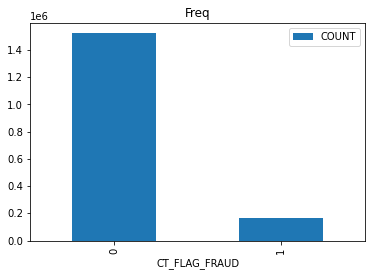

In [9]:
%matplotlib inline
df_col_frequency.plot.bar(x = 'CT_FLAG_FRAUD',
                          y = 'COUNT',
                          title = 'Freq');

### Inspect fraud percentage by hour and whether transaction is at a virtual store or not

Increase fraud percentage of transactions in the night at merchants that are not virtual stores
- Strategy: get transactions and partition data using a random number generator and the PAL function

In [10]:
df_hour_physical = conn.sql("select CT_ID, CT_FLAG_FRAUD \
                            from BIUSER.CARD_TRANSACTIONS_JULY_2020 t, SOURCEDATA.MERCHANT_CA m \
                            where t.CT_MER_ID = m.MER_ID and ( hour(CT_DATE) <= 5 or hour(CT_DATE) >= 22) and m.MER_FLAG_VIRTUAL_STORE = 0")

In [11]:
df_hour_physical.head(5).collect()

,CT_ID,CT_FLAG_FRAUD
0,129814245,1
1,129861468,0
2,129813639,0
3,129813503,0
4,129865822,0


In [12]:
df_hour_physical.count()

168459

In [13]:
df_hour_physical.select_statement

'select CT_ID, CT_FLAG_FRAUD                             from BIUSER.CARD_TRANSACTIONS_JULY_2020 t, SOURCEDATA.MERCHANT_CA m                             where t.CT_MER_ID = m.MER_ID and ( hour(CT_DATE) <= 5 or hour(CT_DATE) >= 22) and m.MER_FLAG_VIRTUAL_STORE = 0'

PAL Partition function needs a physical table; and cannot use views unfortunately. Using a temporary table instead.

In [14]:
from hana_ml.algorithms.pal import partition
df_hour_physical_sample, df_hour_physical_ignore1, df_hour_physical_ignore2 = partition.train_test_val_split(
                               data = df_hour_physical, 
                               random_seed = 4242,
                               training_percentage = 0.25, 
                               testing_percentage = 0.50, 
                               validation_percentage = 0.25)

In [15]:
df_hour_physical_sample.head(5).collect()

,CT_ID,CT_FLAG_FRAUD
0,129861468,0
1,129813639,0
2,129865822,0
3,129862973,1
4,129812312,0


In [16]:
df_hour_physical_sample.count()

42115

For these subset of transactions: 25% of the transactions that were done in the night at merchants that are not physical stores, we will set the fraud flag to 1.

### Inspect fraud percentage by weekday. More fraud transactions in weekend

In [17]:
df_weekday = conn.sql("select CT_ID, CT_FLAG_FRAUD \
from BIUSER.CARD_TRANSACTIONS_JULY_2020 t \
where weekday(CT_DAYDATE) >= 5 and CT_FLAG_FRAUD = 0")

In [18]:
df_weekday.head(5).collect()

,CT_ID,CT_FLAG_FRAUD
0,130406588,0
1,130822075,0
2,130465387,0
3,130073785,0
4,130445775,0


In [19]:
df_weekday.count()

378401

In [20]:
df_weekday_sample, df_weekday_ignore1, df_weekday_ignore2 = partition.train_test_val_split(
                               data = df_weekday, 
                               random_seed = 4242,
                               training_percentage = 0.05, 
                               testing_percentage = 0.50, 
                               validation_percentage = 0.45)

In [21]:
df_weekday_sample.count()

18920

For these subset of transactions - 5% of the weekend transactions are set to fraud compared to 2% during the rest of the week days

### Inspect fraud percentage when average spend is higher in July compared to before that per customer

In [22]:
df_avg_spend_july = conn.sql("select CT_ID, CT_FLAG_FRAUD from ( \
select t.*, case when c.AVG_SPEND_2020 = 0 then 0 else round(t.CT_AMOUNT / c.AVG_SPEND_2020, 2) end as RATIO_AMOUNT_AVG_SPEND_2020 \
from BIUSER.CARD_TRANSACTIONS_JULY_2020 t, \
( \
select CT_CUST_ID, avg(CT_AMOUNT) as AVG_SPEND_2020 \
from SOURCEDATA.VT_CARD_TRANSACTIONS \
where CT_DATE < '2020-07-01' \
group by CT_CUST_ID \
) c \
where t.CT_CUST_ID = c.CT_CUST_ID \
) \
where RATIO_AMOUNT_AVG_SPEND_2020 >= 2 and CT_FLAG_FRAUD = 0")

In [23]:
df_avg_spend_july.count()

120757

In [24]:
df_avg_spend_july_sample, df_avg_spend_july_ignore1, df_avg_spend_july_ignore2 = partition.train_test_val_split(
                               data = df_avg_spend_july, 
                               random_seed = 4242,
                               training_percentage = 0.20, 
                               testing_percentage = 0.50, 
                               validation_percentage = 0.30)

In [25]:
df_avg_spend_july_sample.count()

24151

For these 20% of transactions with more than double the previous average spend, we can consider them fraud.

### Inspect fraud percentage when there is more spend per transaction compared to customer average or lifetime spend, and income

In [26]:
df_customer = conn.sql("select CT_ID, CT_FLAG_FRAUD \
from ( \
select t.*, \
case when c.CUST_AVG_SPEND = 0 then 0 else round(t.CT_AMOUNT / c.CUST_AVG_SPEND, 2) end as RATIO_AMOUNT_AVG_SPEND, \
case when c.CUST_LIFE_SPEND = 0 then 0 else round(t.CT_AMOUNT / c.CUST_LIFE_SPEND, 2) end as RATIO_AMOUNT_LIFE_SPEND, \
case when c.CUST_INCOME = 0 then 0 else round(t.CT_AMOUNT / c.CUST_INCOME, 2) end as RATIO_AMOUNT_INCOME \
from BIUSER.CARD_TRANSACTIONS_JULY_2020 t, SOURCEDATA.CUSTOMER c \
where t.CT_CUST_ID = c.CUST_ID \
) \
where ( RATIO_AMOUNT_AVG_SPEND > 0.25 or RATIO_AMOUNT_LIFE_SPEND > 0.05 or RATIO_AMOUNT_INCOME > 0.25) and CT_FLAG_FRAUD = 0")

In [27]:
df_customer.count()

24020

In [28]:
df_customer_sample, df_customer_ignore1, df_customer_ignore2 = partition.train_test_val_split(
                               data = df_customer, 
                               random_seed = 4242,
                               training_percentage = 0.25, 
                               testing_percentage = 0.50, 
                               validation_percentage = 0.25)

In [29]:
df_customer_sample.count()

6005

### Inspect fraud percentage when there is increased spend compared to card limit

In [30]:
df_card = conn.sql("select CT_ID, CT_FLAG_FRAUD \
from ( \
select t.*, CARD_INTERNATIONAL, \
case when c.CARD_LIMIT = 0 then 0 else round(t.CT_AMOUNT / c.CARD_LIMIT, 2) end as RATIO_AMOUNT_LIMIT \
from BIUSER.CARD_TRANSACTIONS_JULY_2020 t, SOURCEDATA.CARD c \
where t.CT_CUST_ID = c.CARD_ID \
) \
where RATIO_AMOUNT_LIMIT > 0.10 or CARD_INTERNATIONAL = 1")

In [31]:
df_card.count()

510243

In [32]:
df_card_sample, df_card_ignore1, df_card_ignore2 = partition.train_test_val_split(
                               data = df_card, 
                               random_seed = 4242,
                               training_percentage = 0.05, 
                               testing_percentage = 0.50, 
                               validation_percentage = 0.45)

In [33]:
df_card_sample.count()

25512

For these subset of transactions - 5% of the high amount or international transactions are set to fraud compared to 2% for the rest of them.

### Inspect fraud percentage when a customer suddenly uses a card at a virtual store in July without previous such history

In [34]:
df_virtual = conn.sql("select CT_ID, CT_FLAG_FRAUD \
from ( \
select t.* \
from BIUSER.CARD_TRANSACTIONS_JULY_2020 t, SOURCEDATA.MERCHANT_CA tm \
where  \
t.CT_MER_ID = tm.MER_ID \
and tm.MER_FLAG_VIRTUAL_STORE not in \
( \
select distinct MER_FLAG_VIRTUAL_STORE as CUST_MERCHANTS \
from SOURCEDATA.VT_CARD_TRANSACTIONS c, SOURCEDATA.MERCHANT_CA m \
where c.CT_DATE < '2020-07-01' \
and c.CT_MER_ID = m.MER_ID \
and CT_CUST_ID = t.CT_CUST_ID \
) \
)")

In [35]:
df_virtual.count()

725

### Inspect fraud percentage when a customer suddenly uses a card at a new merchant segment in July without previous such history

In [36]:
df_merchant = conn.sql("select CT_ID, CT_FLAG_FRAUD from ( select t.* from BIUSER.CARD_TRANSACTIONS_JULY_2020 t, SOURCEDATA.MERCHANT_CA tm \
where t.CT_MER_ID = tm.MER_ID and tm.MER_SEGMENT not in \
( select distinct MER_SEGMENT as CUST_MERCHANTS from SOURCEDATA.VT_CARD_TRANSACTIONS c, SOURCEDATA.MERCHANT_CA m \
where c.CT_DATE < '2020-07-01' and c.CT_MER_ID = m.MER_ID and CT_CUST_ID = t.CT_CUST_ID ))")

In [37]:
df_merchant.count()

6293

### Combine all the cases where fraud flag needs to be updated

In [38]:
df_final = df_hour_physical_sample.union(df_weekday_sample).union(df_avg_spend_july_sample).union(df_customer_sample).union(df_card_sample).union(df_virtual).union(df_merchant)


In [39]:
df_final.count()

123721

### Save the new subset of data as a table in HANA
In this notebook new fraud cases were created, and we will update the original BIUSER.CARD_TRANSACTIONS_JULY_2020 table with the new cases.

In [40]:
df_pushdown_result = df_final.save(where = ('BIUSER', 'CARD_IDS_FRAUD_JULY_2020'), force = True)

The following SQL command was run on the HANA Cloud database using WebIDE
"UPDATE BIUSER.CARD_TRANSACTIONS_JULY_2020 set CT_FLAG_FRAUD = 1 where CT_ID in (select CT_ID from BIUSER.CARD_IDS_FRAUD_JULY_2020);"

### Close connection

In [41]:
conn.close()